<center><b>  <span style="font-size:24px;">FINA 4335 -Final Project-<span style="color:red;">Part II <span></span></b>
<center><span style="font-size:22px;"><b>Due date: 12/11/2024 11:59 PM ET</b></span></center>
            
##### First name and Last name (team member 1): Stephen Magliocchino
##### First name and Last name (team member 2): Benjamin Damon
##### First name and Last name (team member 3): Benjamin Inglesby

## Instructions
1. Please rename the notebook. It should have the following format: **Final Project_Part II_Lastname1_Lastname2** if there are 2 members in the team.
1. Use this **template** and you are free to add more code/markdown cells. Change the markdown cells if necessary. Well format this notebook file.
1. After you answer all questions:
    1. Restart your kernel and run all cells
    1. Save your notebook and export your notebook as HTML
    1. Submit the **notebook** and **HTML** to Canvas, under Final Group Project.

## Some Grading Guidelines
1. All code cells (excluding evaluation cells) should be **executable**. 
    - Non-executable code cells will receive up to **50%** of grade deduction. To receive more partial credit for a non-executable code cell, ensure it includes sufficient comments.
1.  <span style="color: blue;">I grade on both **correctness** and **effort**</span>
    - **Suppose you don’t know how to generate a specific variable, then you <span style="color: red;">may use random values (with somewhat reasonable range) to replace the variable</span>. You will lose point for that variable but will get most credit for subsequent questions.**
1. Write efficient and clean code
    -  No repetitive code (An example of repetitive code: import the same csv file twice).
    - Informative variable names (if not specified in the project description).
    - Less than 2 uncommented `print`, `.describe()`, or similar quality check in every code cell or every 5 lines of code.
    - Every 2 occurrence of inefficient or inclean code will receive **1 point deduction**
1. Preserve as many observations as possible
    - Losing observations is considered partially incorrect code
    - Do not fill NAs
1. Include sufficient comments (at least 1 comment every 3 lines of code)
      - Failure to include sufficient comments will result in a **5 points** grade deduction
1. Format the markdown file such as including headings and brief question description
1. Use the methods and formulas **covered in the lecture notebooks**. Using formulas inconsistent to the lecture notebooks receives 20% of grade penalty
1. Reasonable code execution time
   - The code execution time for this Part should be less than 20 minutes, otherwise **deduct 1 point for every 5 minutes more code execuation time**
1. **10% of grade penalty per day late, receive 0% if the project is submitted after Dec 13 11:59 PM ET.**

In [586]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy.stats as stats 
import statsmodels.api as sm
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
%config InlineBackend.figure_format = 'retina'
# Measure execution time
start_time_part2 = time.time()  # Start time

## Data preparation (5 points)
**Explanation of variables in 'weekly_rets.csv'**

- **DATE**: This variable represents the last trading day of each week.
- **PERMNO**: This is a unique identifier assigned to each security.
- **ret**: the stock's weekly return, expressed as a decimal.
  
**Explanation of variables in 'monthly_rets_funda.csv'**

- **DATE**: This variable represents the last trading day of each month.
- **PERMNO**: This is a unique identifier assigned to each security.
- **PRC**: reflects the **unadjusted** close price of a stock on the last trading day of the month. This value is the raw closing price without adjustments for corporate actions such as stock splits, dividends, or other modifications.
- **RET**: the stock's monthly return, expressed as a decimal. 
- **SHROUT**: The **shares outstanding** (SHROUT) variable represents the number of shares (in thousands) of a company’s stock that are currently held by all shareholders.
- **revenues**:  This variable represents the total revenues for a specific fiscal year. The variable is already 'lagged'.

In [587]:
# Write your code in the provided code cell; you can add more cells (same applies below, no further repetition).
weekly_rets = pd.read_csv('weekly_rets.csv', parse_dates=['DATE'])
monthly_rets = pd.read_csv('monthly_rets_funda.csv', parse_dates=['DATE'])
weekly_rets.sort_values(by=['PERMNO', 'DATE'], inplace=True)
monthly_rets.sort_values(by=['PERMNO', 'DATE'], inplace=True)
mrets_with_signals = monthly_rets.copy()

In [588]:
# Evaluation cell (used for grading-I don't have a TA)
# you don't need to worry at all if you think certain valuation cell is wrong (same applies below, no further repetition)
print(weekly_rets.head())
print(monthly_rets.head())

        DATE  PERMNO     ret
0 2008-01-04   10001 -0.0283
1 2008-01-11   10001 -0.0131
2 2008-01-18   10001 -0.0047
3 2008-01-25   10001  0.0029
4 2008-02-01   10001  0.0269
        DATE  PERMNO     PRC     RET    SHROUT  revenues
0 2008-01-31   10001 13.9860 -0.0061 2872.1250   84.2780
1 2008-02-29   10001  9.4904  0.0217 4340.6550   84.2780
2 2008-03-31   10001  8.9560 -0.0525 4342.6530   84.2780
3 2008-04-30   10001  8.5914 -0.0367 4342.6530   84.2780
4 2008-05-30   10001 10.8891  0.2714 4342.6530   84.2780


## Constructing factors (33 points; 15+8+5+5)

### Create signals  (3*5=15 points)

#### price_to_sales

In [589]:
# revenue is already 'lagged'
mrets_with_signals['price_to_sales'] = mrets_with_signals['PRC'] / mrets_with_signals['revenues']

In [590]:
# some quality check such as .describe() and print head of key variables
print(mrets_with_signals.describe())
print(mrets_with_signals.isnull().sum())
print(mrets_with_signals.head())

                                DATE      PERMNO         PRC         RET  \
count                         527919 527919.0000 525406.0000 525388.0000   
mean   2015-12-02 04:09:19.313076224  58495.6904     37.2192      0.0093   
min              2008-01-31 00:00:00  10001.0000      0.0170     -0.9712   
25%              2011-09-30 00:00:00  18838.0000      5.1548     -0.0727   
50%              2015-10-30 00:00:00  76750.0000     17.0329      0.0020   
75%              2020-01-31 00:00:00  87377.0000     41.3087      0.0745   
max              2023-12-29 00:00:00  93436.0000   6993.4497     17.5870   
std                              NaN  32011.1641    109.5020      0.1989   

             SHROUT    revenues  price_to_sales  
count   527919.0000 505997.0000     503601.0000  
mean    133605.1067   4137.7446          1.8431  
min          8.9910  -1964.9990       -165.2757  
25%      19541.4390     91.0160          0.0108  
50%      42061.8960    504.3860          0.0335  
75%      94739.

#### ret_2to12m

In [591]:
# Each signal is only worth 3 points. Suppose you don’t know how to generate a specific signal, then you may use random values 
# (with somewhat reasonable range) to replace the signal. You will lose 3 points but will get most credit for subsequent questions.
mrets_with_signals['ret_2to12m'] = (1 + mrets_with_signals['RET']).shift(2) * (1 + mrets_with_signals['RET']).shift(12) - 1

In [592]:
# some quality check such as .describe() and print head of key variables



#### ret_2w

In [593]:
# Each signal is only worth 3 points. Suppose you don’t know how to generate a specific signal, then you may use random values 
# (with somewhat reasonable range) to replace the signal. You will lose 3 points but will get most credit for subsequent questions.

temp_weekly_rets = weekly_rets.copy(deep=True)
# Ensure ret column exists in weekly_rets
temp_weekly_rets['ret'] = temp_weekly_rets['ret'].fillna(0)  # Replace NaNs with 0 for safe return calculations

# Calculate ret_2w for each PERMNO
temp_weekly_rets['ret_2w'] = (1 + temp_weekly_rets['ret']).shift(1) * (1 + temp_weekly_rets['ret']).shift(2) - 1

# Merge ret_2w into mrets_with_signals
mrets_with_signals = mrets_with_signals.merge(
    temp_weekly_rets[['PERMNO', 'DATE', 'ret_2w']],
    on=['PERMNO', 'DATE'],
    how='left'
)

print(mrets_with_signals.head())


        DATE  PERMNO     PRC     RET    SHROUT  revenues  price_to_sales  \
0 2008-01-31   10001 13.9860 -0.0061 2872.1250   84.2780          0.1660   
1 2008-02-29   10001  9.4904  0.0217 4340.6550   84.2780          0.1126   
2 2008-03-31   10001  8.9560 -0.0525 4342.6530   84.2780          0.1063   
3 2008-04-30   10001  8.5914 -0.0367 4342.6530   84.2780          0.1019   
4 2008-05-30   10001 10.8891  0.2714 4342.6530   84.2780          0.1292   

   ret_2to12m  ret_2w  
0         NaN     NaN  
1         NaN -0.0290  
2         NaN     NaN  
3         NaN     NaN  
4         NaN  0.1708  


In [594]:
# some quality check such as .describe() and print head of key variables
print(mrets_with_signals.dropna().shape)
print(mrets_with_signals.shape)


(223675, 9)
(527919, 9)


#### mcap_quarter

In [595]:
# Each signal is only worth 3 points. Suppose you don’t know how to generate a specific signal, then you may use random values 
# (with somewhat reasonable range) to replace the signal. You will lose 3 points but will get most credit for subsequent questions.
mrets_with_signals['mcap_quarter'] = mrets_with_signals['PRC'] * mrets_with_signals['SHROUT']

In [596]:
# some quality check such as .describe() and print head of key variables
print(mrets_with_signals.describe())
print(mrets_with_signals.isnull().sum())
print(mrets_with_signals.head())

                                DATE      PERMNO         PRC         RET  \
count                         527919 527919.0000 525406.0000 525388.0000   
mean   2015-12-02 04:09:19.313076224  58495.6904     37.2192      0.0093   
min              2008-01-31 00:00:00  10001.0000      0.0170     -0.9712   
25%              2011-09-30 00:00:00  18838.0000      5.1548     -0.0727   
50%              2015-10-30 00:00:00  76750.0000     17.0329      0.0020   
75%              2020-01-31 00:00:00  87377.0000     41.3087      0.0745   
max              2023-12-29 00:00:00  93436.0000   6993.4497     17.5870   
std                              NaN  32011.1641    109.5020      0.1989   

             SHROUT    revenues  price_to_sales  ret_2to12m      ret_2w  \
count   527919.0000 505997.0000     503601.0000 522860.0000 235726.0000   
mean    133605.1067   4137.7446          1.8431      0.0191     -0.0001   
min          8.9910  -1964.9990       -165.2757     -0.9729     -0.9545   
25%      19541.

#### beta

In [597]:
temp_weekly_rets = weekly_rets.copy(deep=True)
temp_weekly_rets['market_ret'] = temp_weekly_rets['ret']  # Replace this with actual market proxy

# Calculate rolling beta for each PERMNO over a 52-week window
def calculate_beta(group):
    # Covariance and variance rolling calculations
    rolling_cov = group['ret'].rolling(window=52, min_periods=24).cov(group['market_ret'])
    rolling_var = group['market_ret'].rolling(window=52, min_periods=24).var()
    return rolling_cov / rolling_var

# Add beta to weekly_rets
temp_weekly_rets['beta'] = temp_weekly_rets.groupby('PERMNO').apply(calculate_beta).reset_index(level=0, drop=True)

# Merge beta into mrets_with_signals
mrets_with_signals = mrets_with_signals.merge(
    temp_weekly_rets[['PERMNO', 'DATE', 'beta']],
    on=['PERMNO', 'DATE'],
    how='left'
)


In [598]:
# some quality check such as .describe() and print head of key variables

mrets_with_signals["beta"].value_counts()

beta
1.0000    19932
1.0000    16985
1.0000    12745
1.0000    11432
1.0000     9051
          ...  
1.0000        1
1.0000        1
1.0000        1
1.0000        1
1.0000        1
Name: count, Length: 798, dtype: int64

In [599]:
print(mrets_with_signals.dropna().shape)
print(mrets_with_signals.shape)


(219097, 11)
(527919, 11)


In [600]:
#############################################################################################################################
# Evaluation cell (used for grading-I don't have a TA)
#############################################################################################################################
some_vars = ['PERMNO','RET']+['price_to_sales', 'ret_2to12m', 'ret_2w', 'mcap_quarter', 'beta']
print(mrets_with_signals[some_vars].head())
mrets_with_signals[some_vars].describe()

   PERMNO     RET  price_to_sales  ret_2to12m  ret_2w  mcap_quarter  beta
0   10001 -0.0061          0.1660         NaN     NaN    40169.5403   NaN
1   10001  0.0217          0.1126         NaN -0.0290    41194.5526   NaN
2   10001 -0.0525          0.1063         NaN     NaN    38892.9523   NaN
3   10001 -0.0367          0.1019         NaN     NaN    37309.4690   NaN
4   10001  0.2714          0.1292         NaN  0.1708    47287.5828   NaN


,PERMNO,RET,price_to_sales,ret_2to12m,ret_2w,mcap_quarter,beta
count,527919.0000,525388.0000,503601.0000,522860.0000,235726.0000,525406.0000,229562.0000
mean,58495.6904,0.0093,1.8431,0.0191,-0.0001,7108534.0376,1.0000
std,32011.1641,0.1989,150.3524,0.2823,0.1284,44099771.7926,0.0000
min,10001.0000,-0.9712,-165.2757,-0.9729,-0.9545,88.1584,1.0000
25%,18838.0000,-0.0727,0.0108,-0.1097,-0.0468,124655.7490,1.0000
50%,76750.0000,0.0020,0.0335,0.0043,0.0003,630442.7357,1.0000
75%,87377.0000,0.0745,0.1060,0.1161,0.0437,2908813.5024,1.0000
max,93436.0000,17.5870,34545.4200,25.2589,7.5932,3065205258.3846,1.0000


In [601]:
# Evaluation cell (used for grading-I don't have a TA)
mrets_with_signals.head()

,DATE,PERMNO,PRC,RET,SHROUT,revenues,price_to_sales,ret_2to12m,ret_2w,mcap_quarter,beta
0,2008-01-31,10001,13.9860,-0.0061,2872.1250,84.2780,0.1660,NaN,NaN,40169.5403,NaN
1,2008-02-29,10001,9.4904,0.0217,4340.6550,84.2780,0.1126,NaN,-0.0290,41194.5526,NaN
2,2008-03-31,10001,8.9560,-0.0525,4342.6530,84.2780,0.1063,NaN,NaN,38892.9523,NaN
3,2008-04-30,10001,8.5914,-0.0367,4342.6530,84.2780,0.1019,NaN,NaN,37309.4690,NaN
4,2008-05-30,10001,10.8891,0.2714,4342.6530,84.2780,0.1292,NaN,0.1708,47287.5828,NaN


### Form time-series portfolios (8 points) 

In [602]:
def calculate_quintile_portfolios(data, signal_col):
    """
    Calculate equal-weighted quintile portfolios and long-short factor.
    Args:
        data: DataFrame with `DATE`, `PERMNO`, `RET`, and signal_col.
        signal_col: The column name for the signal to form quintiles.
    Returns:
        DataFrame with quintile portfolio returns and long-short factor.
    """
    quintiles = []
    for date, group in data.groupby('DATE'):
        # Check if the group has enough unique values for quintiles
        if group[signal_col].nunique() < 5:
            print(f"Skipping {date}: Not enough unique values for quintiles.")
            continue

        try:
            # Assign quintiles based on the signal, dropping duplicate edges
            group['quintile'] = pd.qcut(group[signal_col], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
        except ValueError as e:
            print(f"Error processing {date}: {e}")
            continue

        # Calculate equal-weighted returns for each quintile
        quintile_returns = group.groupby('quintile')['RET'].mean()
        quintile_returns['long_short'] = quintile_returns[5] - quintile_returns[1]

        # Store the result
        quintiles.append(pd.Series(quintile_returns, name=date))

    # Combine results into a single DataFrame
    quintile_df = pd.DataFrame(quintiles).sort_index()
    return quintile_df

In [603]:
# Signals to evaluate
signals = {
    'value': 'price_to_sales',
    'momentum': 'ret_2to12m',
    'reversal': 'ret_2w',
    'size': 'mcap_quarter',
    'beta': 'beta'
}

# Create DataFrames for each signal
results = {}
for signal_name, signal_col in signals.items():
    print(f"Processing signal: {signal_name}")
    results[f"{signal_name}_df"] = calculate_quintile_portfolios(mrets_with_signals, signal_col)


Processing signal: value
Processing signal: momentum
Processing signal: reversal
Skipping 2008-01-31 00:00:00: Not enough unique values for quintiles.
Skipping 2008-03-31 00:00:00: Not enough unique values for quintiles.
Skipping 2008-04-30 00:00:00: Not enough unique values for quintiles.
Skipping 2008-06-30 00:00:00: Not enough unique values for quintiles.
Skipping 2008-07-31 00:00:00: Not enough unique values for quintiles.
Skipping 2008-09-30 00:00:00: Not enough unique values for quintiles.
Skipping 2008-12-31 00:00:00: Not enough unique values for quintiles.
Skipping 2009-03-31 00:00:00: Not enough unique values for quintiles.
Skipping 2009-04-30 00:00:00: Not enough unique values for quintiles.
Skipping 2009-06-30 00:00:00: Not enough unique values for quintiles.
Skipping 2009-08-31 00:00:00: Not enough unique values for quintiles.
Skipping 2009-09-30 00:00:00: Not enough unique values for quintiles.
Skipping 2009-11-30 00:00:00: Not enough unique values for quintiles.
Skipping 

In [604]:
# Extract individual DataFrames
value_df = results['value_df']
momentum_df = results['momentum_df']
reversal_df = results['reversal_df']
size_df = results['size_df']
beta_df = results['beta_df']

# Display an example
print("Value Quintile Portfolio:")
print(value_df.head())

Value Quintile Portfolio:
quintile         1       2       3       4       5  long_short
2008-01-31 -0.0496 -0.0657 -0.0731 -0.0626 -0.0695     -0.0200
2008-02-29 -0.0495 -0.0160 -0.0148 -0.0187 -0.0015      0.0480
2008-03-31 -0.0266 -0.0146 -0.0241 -0.0163 -0.0206      0.0061
2008-04-30  0.0185  0.0346  0.0281  0.0367  0.0540      0.0355
2008-05-30  0.0356  0.0408  0.0508  0.0543  0.0603      0.0248


In [605]:
# Evaluation cell (used for grading-I don't have a TA)
print(value_df.head())
value_df.describe()

quintile         1       2       3       4       5  long_short
2008-01-31 -0.0496 -0.0657 -0.0731 -0.0626 -0.0695     -0.0200
2008-02-29 -0.0495 -0.0160 -0.0148 -0.0187 -0.0015      0.0480
2008-03-31 -0.0266 -0.0146 -0.0241 -0.0163 -0.0206      0.0061
2008-04-30  0.0185  0.0346  0.0281  0.0367  0.0540      0.0355
2008-05-30  0.0356  0.0408  0.0508  0.0543  0.0603      0.0248


quintile,1,2,3,4,5,long_short
count,192.0000,192.0000,192.0000,192.0000,192.0000,192.0000
mean,-0.0010,0.0063,0.0092,0.0131,0.0224,0.0234
std,0.0812,0.0696,0.0633,0.0600,0.0693,0.0464
min,-0.3381,-0.2531,-0.2331,-0.1830,-0.1775,-0.1710
25%,-0.0375,-0.0275,-0.0232,-0.0170,-0.0149,0.0026
50%,0.0010,0.0101,0.0133,0.0136,0.0207,0.0212
75%,0.0395,0.0427,0.0451,0.0509,0.0614,0.0462
max,0.3467,0.2647,0.2190,0.1933,0.2626,0.1907


In [606]:
# Evaluation cell (do not change; used for grading)
print(momentum_df.head())
momentum_df.describe()

quintile         1       2       3       4       5  long_short
2008-01-31 -0.0592 -0.0650 -0.0664 -0.0602 -0.0704     -0.0112
2008-02-29 -0.0164 -0.0114 -0.0308 -0.0216 -0.0166     -0.0003
2008-03-31 -0.0228 -0.0231 -0.0201 -0.0107 -0.0304     -0.0076
2008-04-30  0.0187  0.0304  0.0272  0.0442  0.0504      0.0318
2008-05-30  0.0570  0.0458  0.0616  0.0366  0.0385     -0.0185


quintile,1,2,3,4,5,long_short
count,192.0000,192.0000,192.0000,192.0000,192.0000,192.0000
mean,0.0098,0.0104,0.0100,0.0097,0.0089,-0.0009
std,0.0876,0.0672,0.0597,0.0585,0.0696,0.0341
min,-0.2507,-0.2384,-0.2304,-0.2313,-0.2158,-0.1419
25%,-0.0345,-0.0243,-0.0209,-0.0212,-0.0240,-0.0169
50%,0.0111,0.0129,0.0150,0.0128,0.0100,0.0005
75%,0.0552,0.0446,0.0418,0.0451,0.0492,0.0180
max,0.3511,0.2443,0.1875,0.1825,0.2163,0.1015


In [607]:
# Evaluation cell (used for grading-I don't have a TA)
print(reversal_df.head())
reversal_df.describe()

quintile         1       2       3       4       5  long_short
2008-02-29 -0.1561 -0.0562 -0.0218  0.0102  0.1227      0.2788
2008-05-30 -0.0849  0.0107  0.0360  0.0798  0.1976      0.2825
2008-08-29 -0.0990  0.0008  0.0309  0.0547  0.1370      0.2360
2008-10-31 -0.3983 -0.2701 -0.2088 -0.1681 -0.0980      0.3003
2008-11-28 -0.3616 -0.2053 -0.1319 -0.0663  0.0421      0.4036


quintile,1,2,3,4,5,long_short
count,87.0000,87.0000,87.0000,87.0000,87.0000,87.0000
mean,-0.1079,-0.0294,0.0034,0.0341,0.1354,0.2433
std,0.0797,0.0610,0.0545,0.0539,0.0861,0.0659
min,-0.3983,-0.2701,-0.2088,-0.1681,-0.0980,-0.0068
25%,-0.1397,-0.0566,-0.0248,0.0031,0.0853,0.2065
50%,-0.0899,-0.0132,0.0116,0.0352,0.1276,0.2279
75%,-0.0541,0.0130,0.0372,0.0686,0.1725,0.2789
max,0.0132,0.0530,0.0935,0.1483,0.4667,0.4939


In [608]:
# Evaluation cell (used for grading-I don't have a TA)
print(size_df.head())
size_df.describe()

quintile         1       2       3       4       5  long_short
2008-01-31 -0.0489 -0.0722 -0.0805 -0.0629 -0.0573     -0.0085
2008-02-29 -0.0176 -0.0363 -0.0287 -0.0169 -0.0017      0.0159
2008-03-31 -0.0827 -0.0346  0.0138 -0.0009 -0.0025      0.0801
2008-04-30 -0.0114  0.0225  0.0307  0.0543  0.0733      0.0847
2008-05-30  0.0211  0.0437  0.0550  0.0680  0.0514      0.0304


quintile,1,2,3,4,5,long_short
count,192.0000,192.0000,192.0000,192.0000,192.0000,192.0000
mean,-0.0140,0.0121,0.0171,0.0176,0.0158,0.0298
std,0.0817,0.0784,0.0753,0.0643,0.0522,0.0536
min,-0.2755,-0.2563,-0.2384,-0.2080,-0.1801,-0.1931
25%,-0.0549,-0.0298,-0.0295,-0.0160,-0.0101,0.0041
50%,-0.0158,0.0110,0.0210,0.0224,0.0190,0.0332
75%,0.0275,0.0573,0.0607,0.0555,0.0468,0.0583
max,0.2686,0.2935,0.2876,0.2496,0.1686,0.1663


In [609]:
# Evaluation cell (used for grading-I don't have a TA)
print(beta_df.head())
beta_df.describe()

quintile         1       2       3       4       5  long_short
2009-01-30 -0.0239 -0.0230 -0.0308 -0.0087 -0.0328     -0.0090
2009-02-27 -0.1249 -0.1018 -0.1098 -0.1161 -0.1208      0.0040
2009-05-29  0.1039  0.0932  0.1323  0.0937  0.0779     -0.0260
2009-07-31  0.0919  0.1132  0.1099  0.0908  0.1001      0.0082
2009-10-30 -0.0566 -0.0629 -0.0601 -0.0631 -0.0465      0.0102


quintile,1,2,3,4,5,long_short
count,82.0000,82.0000,82.0000,82.0000,82.0000,82.0000
mean,0.0088,0.0117,0.0176,0.0104,0.0080,-0.0008
std,0.0532,0.0597,0.0640,0.0567,0.0509,0.0073
min,-0.1249,-0.1303,-0.1251,-0.1161,-0.1208,-0.0260
25%,-0.0238,-0.0212,-0.0165,-0.0195,-0.0205,-0.0055
50%,0.0103,0.0097,0.0210,0.0119,0.0123,0.0004
75%,0.0469,0.0492,0.0584,0.0508,0.0422,0.0038
max,0.1039,0.1465,0.1840,0.1227,0.1001,0.0148


### plot (5 points)

/var/folders/1b/vm9vwcxd62s4cvv71njdc7140000gv/T/ipykernel_85279/1771660044.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


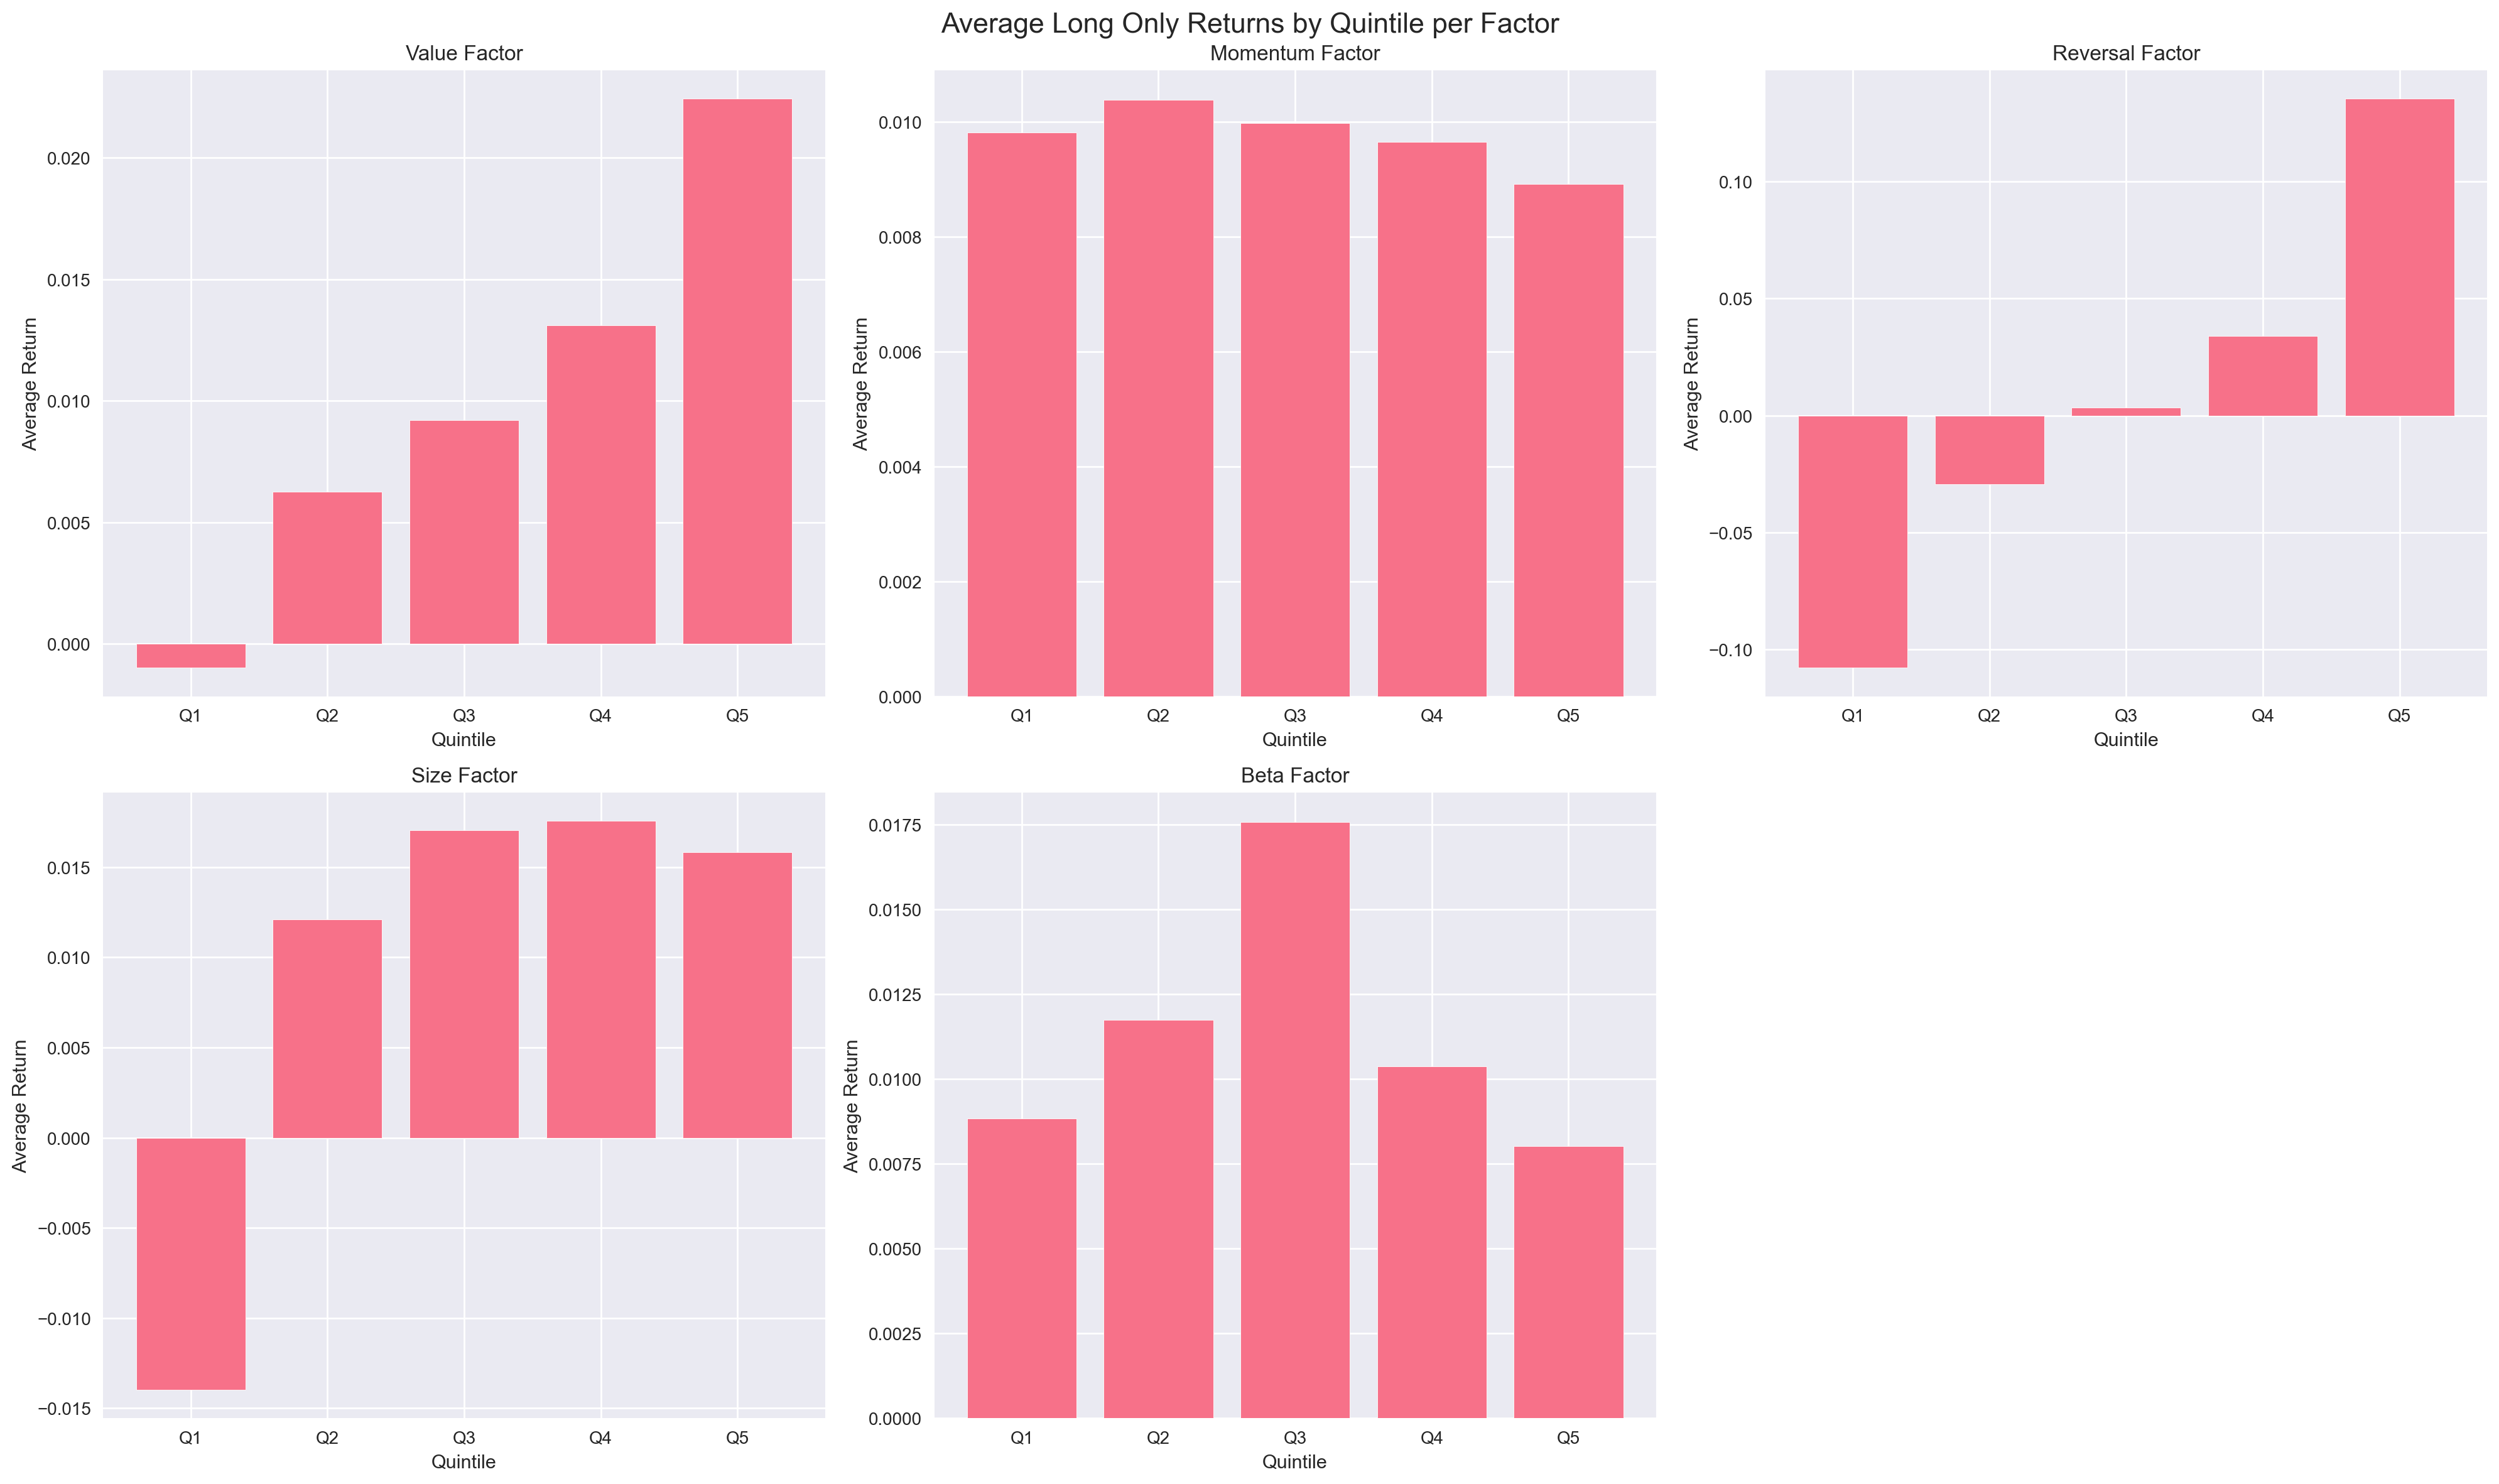

In [610]:
#Set up the plot style
plt.style.use('seaborn')
sns.set_palette("husl")

# Create 2 rows of plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Average Long Only Returns by Quintile per Factor', fontsize=16)
axes_flat = axes.flatten()

# List of dfs
dfs = [
    (value_df, 'Value'),
    (momentum_df, 'Momentum'), 
    (reversal_df, 'Reversal'), 
    (size_df, 'Size'), 
    (beta_df, 'Beta')
]

#plot each df
for i, (df, factor_name) in enumerate(dfs):
    # Select only long only
    quintile_cols = [1, 2, 3, 4, 5]
    
    # Get average returns
    avg_returns = df[quintile_cols].mean()
    axes_flat[i].bar(range(1, 6), avg_returns)
    
    #Labels
    axes_flat[i].set_title(f'{factor_name} Factor')
    axes_flat[i].set_xlabel('Quintile')
    axes_flat[i].set_ylabel('Average Return')
    axes_flat[i].set_xticks(range(1, 6))
    axes_flat[i].set_xticklabels([f'Q{j}' for j in range(1, 6)])

#remove the unused subplot in the second row, adjust layout
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('factor_quintile_average_returns.png', dpi=300, bbox_inches='tight')

#plot
plt.show()

### Save the 5 long-short factor returns in a DataFrame called `factors_df`. (Do not drop any missing values). (5 points)

In [611]:
#Compile L/S data
long_short_data = {
    'value': value_df['long_short'],
    'momentum': momentum_df['long_short'],
    'reversal': reversal_df['long_short'],
    'size': size_df['long_short'],
    'beta': beta_df['long_short']
}

# Create a new DataFrame with LS data
factors_df = pd.DataFrame(long_short_data)
print(factors_df.head())

             value  momentum  reversal    size  beta
2008-01-31 -0.0200   -0.0112       NaN -0.0085   NaN
2008-02-29  0.0480   -0.0003    0.2788  0.0159   NaN
2008-03-31  0.0061   -0.0076       NaN  0.0801   NaN
2008-04-30  0.0355    0.0318       NaN  0.0847   NaN
2008-05-30  0.0248   -0.0185    0.2825  0.0304   NaN


In [612]:
# Evaluation cell (used for grading-I don't have a TA)
print(factors_df.head())
factors_df.describe()

             value  momentum  reversal    size  beta
2008-01-31 -0.0200   -0.0112       NaN -0.0085   NaN
2008-02-29  0.0480   -0.0003    0.2788  0.0159   NaN
2008-03-31  0.0061   -0.0076       NaN  0.0801   NaN
2008-04-30  0.0355    0.0318       NaN  0.0847   NaN
2008-05-30  0.0248   -0.0185    0.2825  0.0304   NaN


,value,momentum,reversal,size,beta
count,192.0000,192.0000,87.0000,192.0000,82.0000
mean,0.0234,-0.0009,0.2433,0.0298,-0.0008
std,0.0464,0.0341,0.0659,0.0536,0.0073
min,-0.1710,-0.1419,-0.0068,-0.1931,-0.0260
25%,0.0026,-0.0169,0.2065,0.0041,-0.0055
50%,0.0212,0.0005,0.2279,0.0332,0.0004
75%,0.0462,0.0180,0.2789,0.0583,0.0038
max,0.1907,0.1015,0.4939,0.1663,0.0148


## Evaluate the factors you created (14 points; 4+4+6)

### Estimate Fama-French 5-factor model for the 5 factor portfolios (in `factors_df`). Report the R squares, regression coefficients, and their p values in a single DataFrame called `ff5_factors_reg`. 

In [613]:
# Prepare the data
ff5_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', 
                            start=mrets_with_signals['DATE'].min(), 
                            end=mrets_with_signals['DATE'].max())[0].div(100)
ff_monthly = (1 + ff5_factors).resample('M').prod() - 1
ff_monthly.index = ff_monthly.index.to_timestamp() + pd.offsets.MonthEnd(0)

# Get monthly factors
common_index = factors_df.index.intersection(ff_monthly.index)

# Prepare the predictors (all 5 Fama-French factors)
X = ff_monthly.loc[common_index, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

# Initialize results storage with correct columns
ff5_factors_reg = pd.DataFrame(columns=['Const_Coef', 'Const_Pval',
                                      'MktRF_Coef', 'MktRF_Pval',
                                      'SMB_Coef', 'SMB_Pval',
                                      'HML_Coef', 'HML_Pval',
                                      'RMW_Coef', 'RMW_Pval',
                                      'CMA_Coef', 'CMA_Pval',
                                      'R_squared'])

# Perform regression for each factor
for factor_name in factors_df.columns:
    # Get the dependent variable, aligning with common index
    y = factors_df.loc[common_index, factor_name]
    
    # Add constant term to the predictors
    X_with_const = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X_with_const).fit()
    
    # Store results
    ff5_factors_reg.loc[factor_name] = [
        model.params[0], model.pvalues[0],  # Const
        model.params[1], model.pvalues[1],  # Mkt-RF
        model.params[2], model.pvalues[2],  # SMB
        model.params[3], model.pvalues[3],  # HML
        model.params[4], model.pvalues[4],  # RMW
        model.params[5], model.pvalues[5],  # CMA
        model.rsquared
    ]

# Print results with better formatting
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\nFama-French 5-Factor Regression Results:")
print(ff5_factors_reg)


Fama-French 5-Factor Regression Results:
          Const_Coef  Const_Pval  MktRF_Coef  MktRF_Pval  SMB_Coef  SMB_Pval  \
value         0.0282      0.0000     -0.4258      0.0000    0.2269    0.0224   
momentum     -0.0018      0.5336     -0.1998      0.0017   -0.2991    0.0122   
reversal         NaN         NaN         NaN         NaN       NaN       NaN   
size          0.0288      0.0000     -0.0609      0.4922   -0.5085    0.0028   
beta             NaN         NaN         NaN         NaN       NaN       NaN   

          HML_Coef  HML_Pval  RMW_Coef  RMW_Pval  CMA_Coef  CMA_Pval  \
value      -0.8044    0.0000   -0.6510    0.0000   -0.1532    0.3211   
momentum   -0.1105    0.3251    0.1717    0.2248    0.3176    0.0872   
reversal       NaN       NaN       NaN       NaN       NaN       NaN   
size       -0.0117    0.9414    0.9177    0.0000    0.2000    0.4448   
beta           NaN       NaN       NaN       NaN       NaN       NaN   

          R_squared  
value        0.7023  


/var/folders/1b/vm9vwcxd62s4cvv71njdc7140000gv/T/ipykernel_85279/3698081786.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench',
/var/folders/1b/vm9vwcxd62s4cvv71njdc7140000gv/T/ipykernel_85279/3698081786.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench',


### Create `factors_sumstat`. 

In [614]:
annual_returns = factors_df.add(1).resample('Y').prod().sub(1)
annual_returns.index = annual_returns.index.year

# Create summary statistics DataFrame
factors_sumstat = pd.DataFrame({
    'Ann_Mean': annual_returns.mean(),
    'Ann_Median': annual_returns.median(),
    'Ann_Std': annual_returns.std()
})

In [615]:
# Evaluation cell (used for grading-I don't have a TA)
print(ff5_factors_reg)
print(factors_sumstat)

          Const_Coef  Const_Pval  MktRF_Coef  MktRF_Pval  SMB_Coef  SMB_Pval  \
value         0.0282      0.0000     -0.4258      0.0000    0.2269    0.0224   
momentum     -0.0018      0.5336     -0.1998      0.0017   -0.2991    0.0122   
reversal         NaN         NaN         NaN         NaN       NaN       NaN   
size          0.0288      0.0000     -0.0609      0.4922   -0.5085    0.0028   
beta             NaN         NaN         NaN         NaN       NaN       NaN   

          HML_Coef  HML_Pval  RMW_Coef  RMW_Pval  CMA_Coef  CMA_Pval  \
value      -0.8044    0.0000   -0.6510    0.0000   -0.1532    0.3211   
momentum   -0.1105    0.3251    0.1717    0.2248    0.3176    0.0872   
reversal       NaN       NaN       NaN       NaN       NaN       NaN   
size       -0.0117    0.9414    0.9177    0.0000    0.2000    0.4448   
beta           NaN       NaN       NaN       NaN       NaN       NaN   

          R_squared  
value        0.7023  
momentum     0.2645  
reversal        NaN 

### Summarize at least three takeaways related to investments based on your results in Part II so far. Cite credible sources that help explain and support your findings. (6 points)

## Factor combination strategy (‘Mission Impossible’) (8 points)
-  You can get partial credit if you have reasonable code.

In [617]:
# List of signals to calculate percentile ranks for
signals = ['price_to_sales', 'ret_2to12m', 'ret_2w', 'mcap_quarter', 'beta']

# Calculate percentile ranks for each signal (1 is worst, 100 is best)
for signal in signals:
    # Calculate percentile rank by date, multiplying by 100 to get 1-100 scale
    mrets_with_signals[f'{signal}_rank'] = mrets_with_signals.groupby('DATE')[signal].rank(pct=True) * 100
    # Invert ranks for signals where lower values are better (like price_to_sales)
    if signal in ['price_to_sales', 'beta']:
        mrets_with_signals[f'{signal}_rank'] = 101 - mrets_with_signals[f'{signal}_rank']

# Calculate the average percentile rank across all signals
rank_columns = [f'{signal}_rank' for signal in signals]
mrets_with_signals['index'] = mrets_with_signals[rank_columns].mean(axis=1)

# Clean up by dropping the intermediate ranking columns
mrets_with_signals.drop(columns=rank_columns, inplace=True)

# Quality checks
print("\nFirst few rows of the new index:")
print(mrets_with_signals[['DATE', 'PERMNO', 'index']].head())

print("\nSummary statistics of the index:")
print(mrets_with_signals['index'].describe())

print("\nCheck for any NaN values in index:")
print(mrets_with_signals['index'].isnull().sum())


First few rows of the new index:
        DATE  PERMNO   index
0 2008-01-31   10001 16.1012
1 2008-02-29   10001 23.9482
2 2008-03-31   10001 19.7681
3 2008-04-30   10001 20.0145
4 2008-05-30   10001 44.3980

Summary statistics of the index:
count   527889.0000
mean        50.2043
std         17.5625
min          0.0364
25%         38.1964
50%         50.6452
75%         62.6749
max        100.2566
Name: index, dtype: float64

Check for any NaN values in index:
30


In [536]:
# Evaluation cell (used for grading-I don't have a TA)
impossible_df

,price_to_sales_rank,ret_2to12m_rank,ret_2w_rank,mcap_quarter_rank,beta_rank,index
0,0.1784,NaN,NaN,0.8799,NaN,NaN
1,0.2388,NaN,0.3258,0.8775,NaN,NaN
2,0.2496,NaN,NaN,0.8831,NaN,NaN
3,0.2574,NaN,NaN,0.8872,NaN,NaN
4,0.2151,NaN,0.9564,0.8635,NaN,NaN
...,...,...,...,...,...,...
527914,0.9140,0.1546,NaN,0.0004,NaN,NaN
527915,0.9164,0.5530,0.4168,0.0005,0.6495,0.5072
527916,0.9333,0.8364,NaN,0.0006,NaN,NaN
527917,0.9197,0.8344,NaN,0.0005,NaN,NaN


In [537]:
end_time_part2 = time.time()  # End time
execution_time_part2 = end_time_part2 - start_time_part2
# Calculate the number of full minutes
minutes = int(execution_time_part2 // 60)
# Calculate the remaining seconds
seconds = int(execution_time_part2 % 60)  
print(f"Execution time for Part II of the project:{minutes} minutes and {seconds} seconds")

Execution time for Part II of the project:0 minutes and 10 seconds
